MOUNT THE DRIVE AND LOAD THE DATASET

In [1]:
#save test set predictions to a file
import os
import sys
import PIL.Image as Image
import matplotlib.pyplot as plt
import torchvision.transforms as tr

In [2]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision.transforms as tr
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os

In [3]:
#general variables
n_epochs=100
cycle_lambda = 10.
root_data = "../harmonies_database"

In [4]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/harmonie/CycleGAN'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd
%ls ../harmonies_database

/content/gdrive/My Drive/Colab Notebooks/harmonie/CycleGAN
analog/  rectangle/


In [6]:
from torch.utils.data import Dataset
import numpy as np

#no time so I'm stealing this from https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/CycleGAN/dataset.py

class HorseZebraDataset(Dataset):
    def __init__(self, root_zebra, root_horse, transform=None):
        self.root_zebra = root_zebra
        self.root_horse = root_horse
        self.transform = transform

        self.zebra_images = os.listdir(root_zebra)
        self.horse_images = os.listdir(root_horse)
        self.length_dataset = max(len(self.zebra_images), len(self.horse_images)) # 1000, 1500
        self.zebra_len = len(self.zebra_images)
        self.horse_len = len(self.horse_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        zebra_img = self.zebra_images[index % self.zebra_len]
        horse_img = self.horse_images[index % self.horse_len]

        zebra_path = os.path.join(self.root_zebra, zebra_img)
        horse_path = os.path.join(self.root_horse, horse_img)

        zebra_img = torch.Tensor(np.moveaxis(np.array(Image.open(zebra_path)),-1,0)).to(torch.device("cuda:0"))/255
        horse_img = torch.Tensor(np.moveaxis(np.array(Image.open(horse_path)),-1,0)).to(torch.device("cuda:0"))/255


        return zebra_img, horse_img

trainData = HorseZebraDataset(os.path.join(root_data,"analog"),os.path.join(root_data,"rectangle"),transform=tr.RandomHorizontalFlip())
iterData = iter(trainData)

Text(0.5, 0, 'analog')

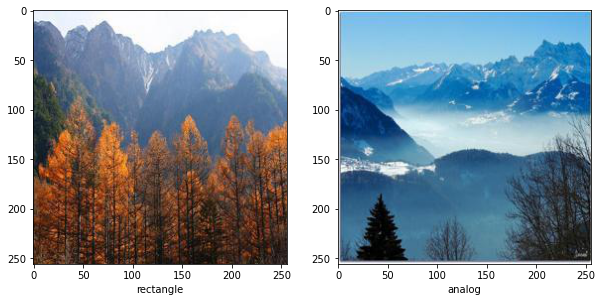

In [7]:
#display a random couple
summer,winter = next(iterData)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(np.moveaxis(np.array(winter.cpu()),0,-1))
plt.xlabel("rectangle")
plt.subplot(1,2,2)
plt.imshow(np.moveaxis(np.array(summer.cpu()),0,-1))
plt.xlabel("analog")

#MODELS

In [8]:
from torch.nn.modules.instancenorm import InstanceNorm2d
class Block(nn.Module):
  def __init__(self,in_chan,out_chan,stride,padding):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_chan,out_chan,4,stride,padding,padding_mode="reflect"),
        nn.InstanceNorm2d(out_chan),
        nn.LeakyReLU(0.2)
    )
  
  def forward(self,X):
    return self.conv(X)

In [19]:
class Discriminator(nn.Module):
  def __init__(self,in_chan=3,features=[64,128,256,512]):
    super().__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(
          in_chan,
          features[0],
          4,stride=2,padding=1,padding_mode="reflect"
        ),
        nn.LeakyReLU(0.2)
    )

    layers=[]
    in_channels=features[0]
    for n_chan in features[1:]:
      layers.append(Block(in_channels,n_chan,2 if n_chan!=features[-1] else 1,1))
      in_channels=n_chan
    self.model = nn.Sequential(*layers)
    self.model.append(
        nn.Sequential(
            nn.Conv2d(in_channels,1,4,1,1,padding_mode="reflect")
            #,nn.Sigmoid()
        )
    )
  
  def forward(self,x):
    x = self.initial(x)
    return self.model(x)

In [10]:
disc = Discriminator().to(torch.device("cuda:0"))
summary(disc,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]               0
         LeakyReLU-5          [-1, 128, 64, 64]               0
             Block-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-8          [-1, 256, 32, 32]               0
         LeakyReLU-9          [-1, 256, 32, 32]               0
            Block-10          [-1, 256, 32, 32]               0
           Conv2d-11          [-1, 512, 31, 31]       2,097,664
   InstanceNorm2d-12          [-1, 512, 31, 31]               0
        LeakyReLU-13          [-1, 512, 31, 31]               0
            Block-14          [-1, 512,

In [11]:
class convBlock(nn.Module):
  def __init__(self,in_channels,out_channels,use_act=True,down=True,**kwargs):
    super().__init__()
    self.block=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,**kwargs)
        if down else
        nn.ConvTranspose2d(in_channels,out_channels,**kwargs),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU() if use_act else nn.Identity()
    )

  def forward(self,x):
    return self.block(x)

In [12]:
class residualBlock(nn.Module):
  def __init__(self,n_channels):
    super().__init__()
    self.block = nn.Sequential(
        convBlock(n_channels,n_channels,kernel_size=3,stride=1,padding=1),
        convBlock(n_channels,n_channels,False,kernel_size=3,stride=1,padding=1)
    )
  def forward(self,x):
    return x + self.block(x)

In [13]:
class Generator(nn.Module):
  def __init__(self,n_residuals=9,in_channels=3,num_features=64):
    super().__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(in_channels,num_features,7,1,3,padding_mode="reflect"),
        nn.ReLU()
        )
    self.down = nn.ModuleList(
        [
        convBlock(num_features,num_features*2,kernel_size=3,stride=2,padding=1),
        convBlock(num_features*2,num_features*4,kernel_size=3,stride=2,padding=1)
        ]
    )
    self.residual=nn.ModuleList(
        [*[residualBlock(num_features*4) for _ in range(n_residuals)]
        ]
    )
    self.up = nn.ModuleList(
        [
        convBlock(num_features*4,num_features*2,kernel_size=3,stride=2,padding=1,output_padding=1,down=False),
        convBlock(num_features*2,num_features*1,kernel_size=3,stride=2,padding=1,output_padding=1,down=False)
        ]
    )
    self.up.append(nn.Sequential(
        nn.Conv2d(num_features,3,7,1,3,padding_mode="reflect"),
        nn.Tanh()
        )
    )

  def forward(self,x):
    x = self.initial(x)
    for d in self.down:
      x = d(x)
    for r in self.residual:
      x = r(x)
    for u in self.up:
      x = u(x)
    return x

In [14]:
gen = Generator(n_residuals=4,num_features=64).to(torch.device("cuda:0"))
#summary(gen,(3,256,256))
print(gen(winter))

tensor([[[ 0.8193,  0.4800,  0.7827,  ...,  0.1032,  0.0770,  0.0960],
         [ 0.7028,  0.5751,  0.4932,  ...,  0.0767, -0.2082,  0.2635],
         [ 0.9346, -0.0626,  0.9076,  ...,  0.1077,  0.3078,  0.1551],
         ...,
         [ 0.1419, -0.0101, -0.0306,  ...,  0.0337, -0.0274,  0.3452],
         [ 0.4522, -0.1461,  0.1298,  ..., -0.0813,  0.2912,  0.0998],
         [ 0.2396,  0.1697,  0.1892,  ...,  0.0781,  0.0050,  0.0253]],

        [[-0.6754, -0.6762, -0.2706,  ...,  0.1153, -0.3289,  0.2269],
         [-0.5470,  0.0539, -0.0538,  ..., -0.2175, -0.3421, -0.0734],
         [-0.1974,  0.4687, -0.8200,  ..., -0.3051,  0.0177,  0.1126],
         ...,
         [-0.0034, -0.0076,  0.0709,  ..., -0.2314,  0.0829,  0.2369],
         [-0.1701,  0.2212, -0.2187,  ...,  0.0082,  0.2586, -0.0252],
         [ 0.1202, -0.0153, -0.3167,  ..., -0.1243,  0.2053,  0.1596]],

        [[ 0.7835, -0.4674,  0.7762,  ..., -0.1353,  0.4434,  0.3190],
         [ 0.4176,  0.7861,  0.7672,  ...,  0

In [1]:
def make_the_models():
  disc_S = Discriminator().to(torch.device("cuda:0"))
  disc_W = Discriminator().to(torch.device("cuda:0"))

  def weight_init(m):
    # weight_initialization: important for wgan
    class_name=m.__class__.__name__
    if class_name.find('Conv')!=-1:
        m.weight.data.normal_(0,0.02)
    elif class_name.find('Norm')!=-1:
        m.weight.data.normal_(1.0,0.02)
    #     else:print(class_name)

  disc_S.apply(weight_init)
  disc_W.apply(weight_init)



  gen_S = Generator(n_residuals=3,num_features=64).to(torch.device("cuda:0"))
  gen_W = Generator(n_residuals=3,num_features=64).to(torch.device("cuda:0"))
  
  opt_d = torch.optim.RMSprop(list(disc_S.parameters())+list(disc_W.parameters()),lr=0.00005)
  opt_g = torch.optim.RMSprop(list(gen_S.parameters())+list(gen_W.parameters()),lr=0.00005)

  return disc_S, disc_W, gen_S, gen_W, opt_d, opt_g, l1, mse

In [16]:
import tqdm

def train(dataset, disc_S, disc_W, gen_S, gen_W, opt_d, opt_g, l1, mse):

  for i in range(n_epochs):
    i=0
    for summer,winter in tqdm.tqdm(dataset):

      #train the discriminators on their own
      with torch.cuda.amp.autocast():

        # modification: clip param for discriminators
        for parm in disc_S.parameters():
                parm.data.clamp_(-opt.clamp_num,opt.clamp_num)
        for parm in disc_W.parameters():
                parm.data.clamp_(-opt.clamp_num,opt.clamp_num)

        #adversarial loss for summer discriminator
        #learn to correctly detect fake summer and real summer (learns both to detect realism AND summer)
        #basically estimating the distribution of summer images through this adversarial loss.
        gen_S.zero_grad()
        fake_summer = gen_S(winter)
        pred_fake_summer = disc_S(fake_summer.detach())
        pred_real_summer = disc_S(summer)
        pred_fake_summer.backward(torch.ones_like(pred_fake_summer))
        pred_real_summer.backward(torch.ones_like(pred_real_summer))

        #adversarial loss for winter discriminator
        gen_W.zero_grad()
        fake_winter = gen_W(summer)
        pred_fake_winter = disc_W(fake_winter.detach())
        pred_real_winter = disc_W(winter)
        pred_fake_winter.backward(torch.ones_like(pred_fake_winter))
        pred_real_winter.backward(torch.ones_like(pred_real_winter))



      opt_d.step()


      #https://github.com/chenyuntc/pytorch-GAN/blob/master/WGAN.ipynb
      
      #train the generators on their own
      with torch.cuda.amp.autocast():
        #adversarial loss on summer generator
        fake_summer = gen_S(winter)
        pred_fake_summer = disc_S(fake_summer)
        loss_gen_S_adv = mse(pred_fake_summer,torch.zeros_like(pred_fake_summer))
        #adversarial loss on winter generator
        fake_winter = gen_W(summer)
        pred_fake_winter = disc_W(fake_winter)
        loss_gen_W_adv = mse(pred_fake_winter,torch.zeros_like(pred_fake_winter))

        #cycle consistency loss for summer->winter->summer (updates both generators)
        reco_summer = gen_S(fake_winter)
        loss_gen_S_cyc = l1(reco_summer,summer)

        #cycle consistency loss for winter->summer->winter (updates both generators)
        reco_winter = gen_W(fake_summer)
        loss_gen_W_cyc = l1(reco_winter,winter)

        #final generators loss
        G_loss = (loss_gen_S_cyc*cycle_lambda + loss_gen_W_cyc*cycle_lambda + loss_gen_S_adv + loss_gen_W_adv)

      if(i==15):
        print("Gloss adv : ",float(loss_gen_S_cyc*cycle_lambda + loss_gen_W_cyc*cycle_lambda),"Gloss adv : ",float(loss_gen_S_adv + loss_gen_W_adv),"D loss : ",float(D_loss))
        i=0
      i+=1
      #update the weights
      opt_g.zero_grad()
      G_loss.backward()
      opt_g.step()

In [17]:
disc_S, disc_W, gen_S, gen_W, opt_d, opt_g, l1, mse = make_the_models()


train(trainData,disc_S, disc_W, gen_S, gen_W, opt_d, opt_g,l1, mse)

  3%|▎         | 16/562 [00:17<08:59,  1.01it/s]

Gloss adv :  5.089801788330078 Gloss adv :  0.6137212514877319 D loss :  0.45920228958129883


  6%|▌         | 31/562 [00:31<08:17,  1.07it/s]

Gloss adv :  3.8920810222625732 Gloss adv :  0.6347944736480713 D loss :  0.44749513268470764


  8%|▊         | 46/562 [00:46<08:09,  1.05it/s]

Gloss adv :  3.271730422973633 Gloss adv :  0.6259397268295288 D loss :  0.4490061402320862


 11%|█         | 61/562 [01:00<08:10,  1.02it/s]

Gloss adv :  3.616769790649414 Gloss adv :  0.5425371527671814 D loss :  0.5025372505187988


 14%|█▎        | 76/562 [01:15<08:06,  1.00s/it]

Gloss adv :  3.5915420055389404 Gloss adv :  0.5830748081207275 D loss :  0.4588974118232727


 16%|█▌        | 91/562 [01:29<07:03,  1.11it/s]

Gloss adv :  4.011264801025391 Gloss adv :  0.6182535886764526 D loss :  0.48823991417884827


 19%|█▉        | 106/562 [01:43<07:19,  1.04it/s]

Gloss adv :  3.1154818534851074 Gloss adv :  0.6446175575256348 D loss :  0.4397147297859192


 22%|██▏       | 121/562 [01:57<06:59,  1.05it/s]

Gloss adv :  3.0929360389709473 Gloss adv :  0.6165135502815247 D loss :  0.4507843554019928


 24%|██▍       | 136/562 [02:11<06:38,  1.07it/s]

Gloss adv :  3.10073184967041 Gloss adv :  0.6248632073402405 D loss :  0.4681165814399719


 27%|██▋       | 151/562 [02:25<06:33,  1.04it/s]

Gloss adv :  2.9957170486450195 Gloss adv :  0.6508424282073975 D loss :  0.469302773475647


 30%|██▉       | 166/562 [02:39<06:13,  1.06it/s]

Gloss adv :  1.6848909854888916 Gloss adv :  0.6434526443481445 D loss :  0.44718173146247864


 31%|███       | 174/562 [02:48<06:15,  1.03it/s]


KeyboardInterrupt: ignored

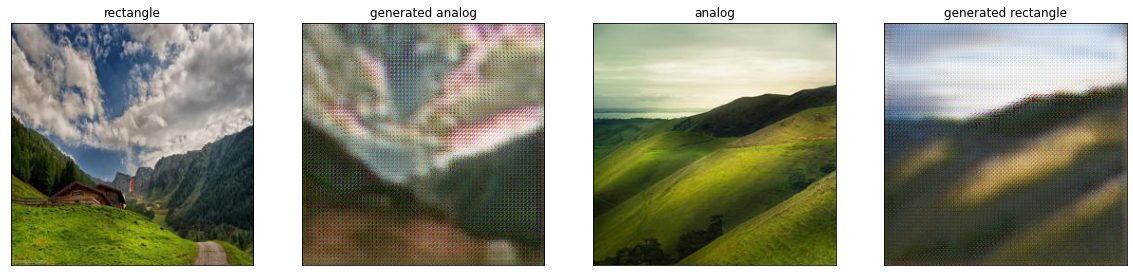

In [18]:
gen_W.to(torch.device("cuda:0"))
#testing results
summer,winter = next(iterData)
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(np.moveaxis(np.array(winter.cpu()),0,-1))
plt.title("rectangle")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.subplot(1,4,2)
plt.imshow(np.moveaxis(np.array(gen_S(winter).cpu().detach()),0,-1))
plt.title("generated analog")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.subplot(1,4,3)
plt.imshow(np.moveaxis(np.array(summer.cpu()),0,-1))
plt.title("analog")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.subplot(1,4,4)
plt.imshow(np.moveaxis(np.array(gen_W(summer).cpu().detach()),0,-1))
plt.title("generated rectangle")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)